In [1]:
import numpy as np
import mxnet as mx
import time
import pandas as pd

import cv2

import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data0 = pd.read_csv('fdata/fdata.csv', names=['name','state'])

In [4]:
data0.head()

,name,state
0,1-closedleft.jpg,initial
1,1-closedmiddle.jpg,initial
2,1-closedright.jpg,initial
3,1-openleft.jpg,ready
4,1-openmiddle.jpg,ready


In [5]:
data0['state'].unique()

array([' initial', ' ready', ' number', ' alphabet1', ' alphabet2',
       ' special1', ' special2', ' special3', ' shift', ' ctrl', ' alt',
       ' 1', ' 2', ' 3', ' 4', ' 5', ' 6', ' 7', ' 8', ' 9', ' 0', ' +',
       ' -', ' *', ' /', ' ='], dtype=object)

In [6]:
num_class = len(data0['state'].unique())
ges_to_num = dict({(g,i) for i, g in enumerate(data0['state'].unique())})
num_to_ges = dict({(i,g) for i, g in enumerate(data0['state'].unique())})
num_class, ges_to_num

(26,
 {' *': 23,
  ' +': 21,
  ' -': 22,
  ' /': 24,
  ' 0': 20,
  ' 1': 11,
  ' 2': 12,
  ' 3': 13,
  ' 4': 14,
  ' 5': 15,
  ' 6': 16,
  ' 7': 17,
  ' 8': 18,
  ' 9': 19,
  ' =': 25,
  ' alphabet1': 3,
  ' alphabet2': 4,
  ' alt': 10,
  ' ctrl': 9,
  ' initial': 0,
  ' number': 2,
  ' ready': 1,
  ' shift': 8,
  ' special1': 5,
  ' special2': 6,
  ' special3': 7})

In [7]:
data0 = data0.replace({'state':ges_to_num})

In [8]:
data0.shape[0]

300

In [36]:
labels = np.empty((data0.shape[0]))

res_width, res_height = 200, 200
imgs = np.empty(shape=(data0.shape[0],3, res_width,res_height))
imgs.shape, labels.shape

((300, 3, 200, 200), (300,))

In [37]:
prefix = 'fdata/hand_pic_v2/'

for i, (im_name, state) in enumerate(data0.values):
    im_path = prefix + im_name
#     print im_path
    img = cv2.imread(im_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    res = cv2.resize(gray,(200, 200), interpolation=cv2.INTER_CUBIC)

    res = np.swapaxes(res, 0, 2)
    res = np.swapaxes(res, 1, 2)
    res = res[np.newaxis, :]

    imgs[i] = res
    labels[i] = state

In [39]:
# plt.imshow(res)

In [40]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_label, test_label = train_test_split(imgs, labels, test_size=0.1, shuffle=True)

In [41]:
# train_data, train_label = imgs, labels
# test_data, test_label = imgs[23:], labels[2:]
train_data.shape, train_label.shape, test_data.shape, test_label.shape

((270, 3, 200, 200), (270,), (30, 3, 200, 200), (30,))

In [42]:
test_label

array([ 17.,   0.,  18.,  25.,   0.,   0.,  13.,  22.,   5.,  19.,  22.,
         1.,   5.,  22.,  21.,  10.,   9.,  22.,   0.,  21.,  18.,  10.,
        24.,  14.,  21.,   3.,  15.,   1.,  22.,   3.])

In [43]:
batch_size = 10
train_iter = mx.io.NDArrayIter(train_data, train_label, batch_size, shuffle=True)
eval_iter = mx.io.NDArrayIter(test_data, test_label, batch_size)

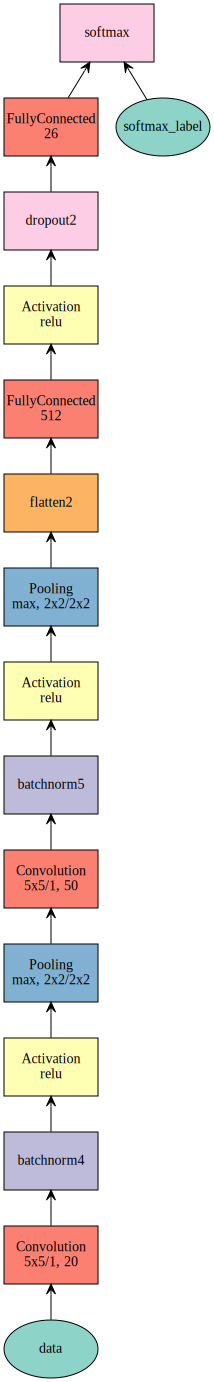

In [52]:
data = mx.sym.var('data')

conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20, name='conv1')
bn1 = mx.sym.BatchNorm(conv1, fix_gamma=True)
tanh1 = mx.sym.Activation(data=bn1, act_type='relu')
pool1 = mx.sym.Pooling(data=tanh1, pool_type='max', kernel=(2,2), stride=(2,2))

conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50, name='conv2')
bn2 = mx.sym.BatchNorm(conv2, fix_gamma=True)
tanh2 = mx.sym.Activation(data=bn2, act_type='relu')
pool2 = mx.sym.Pooling(data=tanh2, pool_type='max', kernel=(2,2), stride=(2,2))

flat = mx.sym.flatten(data=pool2)
fc1 = mx.sym.FullyConnected(data=flat, num_hidden=512)
tanh3 = mx.sym.Activation(data=fc1, act_type='relu')

drop = mx.symbol.Dropout(tanh3, p=0.5)
fc2 = mx.sym.FullyConnected(data=drop, num_hidden=num_class)

convnet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

mx.viz.plot_network(convnet)

In [53]:
model = mx.mod.Module(symbol=convnet, context=mx.gpu())

In [54]:
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params(initializer=mx.init.Uniform(scale=.01))
model.init_optimizer(optimizer='sgd', optimizer_params={'learning_rate':0.001})

metric = mx.metric.Accuracy()

In [61]:
chk_prefix='models/chkpt'
for epoch in range(10):
    train_iter.reset()
    metric.reset()
    
    st = time.time()
    for batch in train_iter:
        model.forward(data_batch=batch, is_train=True)
        model.update_metric(metric, batch.label)
        model.backward()
        model.update()
    
    if epoch % 50 == 0:
#         model_path = '{}_{}'.format(chk_prefix, epoch)
        model.save_checkpoint(chk_prefix, epoch)
        
    et = time.time()-st
    print('Epoch %d, Training %s, Time %.2f' % (epoch, metric.get(), et))

INFO:root:Saved checkpoint to "models/chkpt-0000.params"


Epoch 0, Training ('accuracy', 0.9666666666666667), Time 3.36
Epoch 1, Training ('accuracy', 0.9703703703703703), Time 1.36
Epoch 2, Training ('accuracy', 0.9888888888888889), Time 1.39
Epoch 3, Training ('accuracy', 0.9851851851851852), Time 1.40
Epoch 4, Training ('accuracy', 0.9962962962962963), Time 1.40
Epoch 5, Training ('accuracy', 0.9888888888888889), Time 1.40
Epoch 6, Training ('accuracy', 0.9925925925925926), Time 1.40
Epoch 7, Training ('accuracy', 0.9851851851851852), Time 1.40
Epoch 8, Training ('accuracy', 0.9925925925925926), Time 1.40
Epoch 9, Training ('accuracy', 0.9962962962962963), Time 1.39


In [62]:
model.score(eval_iter, metric)

[('accuracy', 0.36666666666666664)]

In [ ]:
# ls data1

In [ ]:
# # I took a picture of my hand
# pred_im = cv2.imread('data1/test-crop.png', 0)
# plt.imshow(pred_im)

In [ ]:
# pred_im.shape

In [ ]:
# pred_res = cv2.resize(pred_im,(200, 200), interpolation = cv2.INTER_CUBIC)
# plt.imshow(pred_res)

In [ ]:
# test_ = np.empty((1,1,200,200))
# test_[0][0] = pred_res
# lb = np.array([0])

In [ ]:
# test_.shape#, lb.shape

In [ ]:
# eval_iter = mx.io.NDArrayIter(test_, lb, batch_size=1)

In [ ]:
# d = Batch([mx.nd.array(pred_res)])
# # d, pred_res.shape
# model.forward(data_batch=d)

In [ ]:
# def get_image(url, show=False):
#     # download and show the image
# #     fname = mx.test_utils.download(url)
# #     img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
#     img = cv2.imread(url, 0)
#     if img is None:
#          return None
#     if show:
#          plt.imshow(img)
#          plt.axis('off')

#     img = cv2.resize(img, (200, 200), interpolation = cv2.INTER_CUBIC)
# #     img = np.swapaxes(img, 0, 2)
# #     img = np.swapaxes(img, 1, 2)
#     img = img[np.newaxis, np.newaxis, :]
#     return img

In [ ]:
# from collections import namedtuple
# Batch = namedtuple('Batch', ['data'])
# def predict(url):
#     img = get_image(url, show=True)
#     print img.shape
#     print Batch([mx.nd.array(img)])
#     # compute the predict probabilities
# #     model.forward(Batch([mx.nd.array(img)]), is_train=False)
# #     prob = mod.get_outputs()[0].asnumpy()
# #     # print the top-5
# #     prob = np.squeeze(prob)
# #     a = np.argsort(prob)[::-1]
# #     for i in a[0:5]:
# #         print('probability=%f, class=%s' %(prob[i], labels[i]))

In [ ]:
# # test picture with label 0
# # pred = model.predict(eval_iter)#.asnumpy()
# predict('data1/test-crop.png')

In [ ]:
# pred.argmax() # correct!

In [ ]:
#    # save a model to mymodel-symbol.json and mymodel-0100.params
#     prefix = 'mymodel'
#     iteration = 100
#     model.save(prefix, iteration)

#     # load model back
#     model_loaded = mx.model.FeedForward.load(prefix, iteration)